# Bimodal Gaussian Fit for Temperature Data

This code performs the following steps to analyze temperature data and fit a bimodal Gaussian distribution to it:

1. **Data Preprocessing**:
   - The temperature data is extracted from the dataset and filtered to exclude values below 400K.
   - The logarithm of the temperature values is applied for further analysis.

2. **Data Segmentation**:
   - The temperature data is separated into two groups: below and above a threshold (6.68), representing the smoldering and flaming phases of the fire, respectively.

3. **Histogram Calculation**:
   - A histogram is created for the data with relative frequency, using weights to account for the distribution of values.
   - The histogram is used to analyze the distribution of the logarithmic temperature values.

4. **Bimodal Gaussian Fit**:
   - The histogram data is fitted using a bimodal Gaussian function. Initial estimates for the Gaussian parameters are provided based on the data.
   - The parameters for the two modes (smoldering and flaming) are optimized using `curve_fit`.

5. **Plotting and Visualization**:
   - A histogram is plotted along with the fitted bimodal Gaussian curve and individual Gaussian components for the smoldering and flaming phases.
   - The exponentiated means and their bounds are also calculated to show the actual temperature values for both phases.
   - The plot is customized with titles, labels, and a legend to provide a clear and informative visualization of the temperature distribution.

The goal of this analysis is to model the temperature distribution using a bimodal Gaussian, which helps distinguish between different phases of fire activity and understand the temperature dynamics of biomass burning.


In [ ]:
# Import necessary libraries for data manipulation, plotting, statistical analysis, and signal processing

# pandas for handling data in DataFrame format
import pandas as pd

# matplotlib for creating static, animated, and interactive plots
import matplotlib.pyplot as plt  

# glob for file path manipulation and finding files that match a given pattern
import glob

# numpy for numerical operations and array handling
import numpy as np

# math module for basic mathematical functions
import math as mt

# scipy: various submodules for advanced scientific computations
from scipy import stats  # for statistical functions and distributions
from scipy.optimize import curve_fit  # for curve fitting optimization
from scipy.stats import lognorm, norm  # for lognormal and normal distributions
from mpl_toolkits.axes_grid1 import make_axes_locatable  # for creating grid layouts in plots
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable  # for fine-tuning axes
from scipy.signal import chirp, find_peaks, peak_widths, find_peaks_cwt  # for signal analysis and peak detection

In [ ]:
# Define the directory where the data files are located
datadir = '/home/jovyan/Article_review/Data'

# Define the year for processing as a string (e.g., 2020)
Year = str(2020)

# Example file name formats: 'array_T_data_2020_150_350.csv' for temperature data and 'goes_area_amazon_definitive_box_2020_150_350.csv' for area data
# Collect all the relevant files based on the year and specific naming pattern
data_area = sorted(glob.glob(datadir+'/*goes_area_amazon_definitive_box_'+str(Year)+'_150_350.csv'))
data_temp = sorted(glob.glob(datadir+'/*array_T_data_'+Year+'_150_350.csv'))

# Read the CSV file containing area data for the specified year and region
dados_area = pd.read_csv(data_area[0])

# Read the CSV file containing temperature data for the specified year and region
temperature_data = pd.read_csv(data_temp[0])

Mean: 0.464
Median: 0.492
N: 26096
10th Percentile: 0.0320
90th Percentile: 6.208


<Figure size 640x480 with 0 Axes>

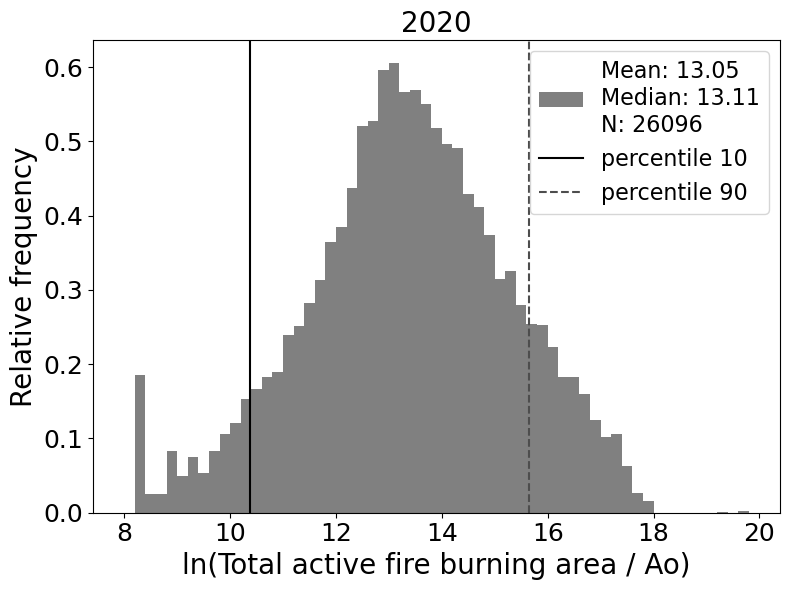

In [7]:
# Function to plot a graph of the distribution of the total burned area
# Extract the header from the data file to list all columns
header = list(dados_area)

# Extract the 'sum_area' column from the data and convert it to a numpy array, dropping any NaN values
pos3 = header.index('sum_area')
column3 = dados_area.iloc[:, pos3]
area = np.array(column3.dropna(), dtype=float)

# Configure the plot's appearance
plt.clf()  # Clear any previous figures
plt.figure(figsize=(8, 6))  # Set the figure size
plt.xlabel('ln(Total active fire burning area / Ao)', fontsize=20)  # Label for the x-axis
plt.ylabel('Relative frequency', fontsize=20)  # Label for the y-axis
plt.tick_params(axis='x', labelsize=18)  # Set font size for x-axis ticks
plt.tick_params(axis='y', labelsize=18)  # Set font size for y-axis ticks

# Select valid (positive) values for the area and apply the natural logarithm transformation
index = np.where((area > 0))  # Find indices where the area is greater than 0
area_index = area[index]  # Get the area values at those indices
area_index = np.log(area_index)  # Take the natural logarithm of the area values

# Define the limits and bin edges for the histogram plot
limites = [8, 20]  # The range of x-values to display in the histogram
pontos_divisao = np.arange(8, 20, 0.2)  # The bin edges for the histogram

# Calculate the relative frequencies for the histogram (normalized)
frequencias_relativas = area_index / len(area_index)

# Plot the histogram of the logarithmic area values
plt.title(str(Year), fontsize=20)  # Set the plot title to the year
Mean = 'Mean: {:.2f}\nMedian: {:.2f}\nN: {:.0f}'.format(np.mean(area_index), np.median(area_index), len(area_index))  # Prepare the mean, median, and count for the legend
plt.hist(area_index, range=limites, bins=pontos_divisao, weights=frequencias_relativas, label=Mean, color='gray')  # Plot the histogram with relative frequencies
plt.axvline(np.percentile(area_index, 10), color='0.0', label='percentile 10')  # Mark the 10th percentile with a vertical line
plt.axvline(np.percentile(area_index, 90), color='0.3', linestyle='--', label='percentile 90')  # Mark the 90th percentile with a dashed vertical line
plt.legend(loc='best', fontsize=16)  # Display the legend in the best location with appropriate font size

plt.tight_layout()  # Adjust layout to avoid overlap
# plt.savefig('filename.png', dpi=200)  # Uncomment to save the figure if needed

# Print out the mean, median, and percentiles of the area (back-transformed to the original scale)
mean_value = np.exp(np.mean(area_index)) / 1e6  # Convert the mean from log scale to original scale (in millions)
median_value = np.exp(np.median(area_index)) / 1e6  # Convert the median from log scale to original scale (in millions)
n_value = len(area_index)  # The number of valid area entries
percentile_10 = np.exp(np.percentile(area_index, 10)) / 1e6  # Convert the 10th percentile from log scale to original scale (in millions)
percentile_90 = np.exp(np.percentile(area_index, 90)) / 1e6  # Convert the 90th percentile from log scale to original scale (in millions)

# Print the summary statistics to the console
print(f"Mean: {mean_value:.3f}")
print(f"Median: {median_value:.3f}")
print(f"N: {n_value}")
print(f"10th Percentile: {percentile_10:.4f}")
print(f"90th Percentile: {percentile_90:.3f}")

In [ ]:
# Bimodal Gaussian function
# This function models a mixture of two Gaussian (normal) distributions.
# It takes the following parameters:
# - x: The input data for the distribution.
# - amplitude1: The amplitude (height) of the first Gaussian curve.
# - mean1: The mean (center) of the first Gaussian curve.
# - std1: The standard deviation (spread) of the first Gaussian curve.
# - amplitude2: The amplitude (height) of the second Gaussian curve.
# - mean2: The mean (center) of the second Gaussian curve (fixed based on literature).
# - std2: The standard deviation (spread) of the second Gaussian curve (fixed based on literature).

def gaussian_bimodal(x, amplitude1, mean1, std1, amplitude2, mean2, std2):
    # Lock the second Gaussian's mean and standard deviation based on literature values
    mean2 = 6.90  # Fixed mean for the second Gaussian curve
    std2 = 0.18  # Fixed standard deviation for the second Gaussian curve
    
    # Compute and return the sum of two Gaussian functions
    return (amplitude1 * np.exp(-(x - mean1) ** 2 / (2 * std1 ** 2)) +
            amplitude2 * np.exp(-(x - mean2) ** 2 / (2 * std2 ** 2)))

# Gaussian function
# This function models a single Gaussian (normal) distribution.
# It takes the following parameters:
# - x: The input data for the distribution.
# - amplitude1: The amplitude (height) of the Gaussian curve.
# - mean1: The mean (center) of the Gaussian curve.
# - std1: The standard deviation (spread) of the Gaussian curve.

def gaussian(x, amplitude1, mean1, std1):
    # Compute and return the value of a single Gaussian function
    return amplitude1 * np.exp(-(x - mean1) ** 2 / (2 * std1 ** 2))

/tmp/ipykernel_1959/643656321.py:38: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters_optimized, _ = curve_fit(gaussian_bimodal, bin_centers, hist, p0=parameters_initial)


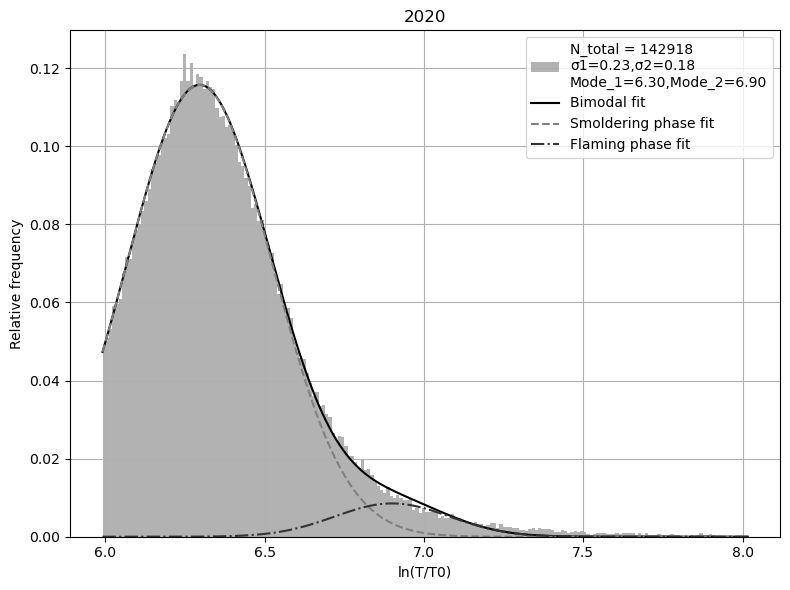

In [5]:
# List the data file header
header = list(temperature_data)

# Extract the 'array_temp' column from the file
pos1 = header.index('array_temp')  # Find the position of the 'array_temp' column
column1 = temperature_data.iloc[:, pos1]  # Select the column data
Temp = np.array(column1.dropna(), dtype=float)  # Convert to numpy array and drop missing values

# Exclude the data below the 400K threshold and apply the logarithm to the temperature data
Temp = Temp[Temp > 400]  # Filter out values below 400K
Temp = np.log(Temp)  # Apply the logarithm transformation to the remaining data

# Separate the data into two groups based on the flaming threshold (~800K)
data1 = Temp[Temp <= 6.68]  # Data below the flaming threshold
data2 = Temp[Temp > 6.68]  # Data above the flaming threshold
data = np.concatenate([data1, data2])  # Combine both groups into one dataset

# Calculate the relative frequency (since np.histogram with weights doesn't work for log-transformed data)
relative_freq = data / len(data)

# Create a histogram with relative frequency
num_bins = 200  # Define the number of bins for the histogram
hist, bin_edges = np.histogram(data, bins=num_bins, range=(min(data), max(data)), weights=relative_freq)  # Generate histogram data

# Calculate the bin centers for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute the midpoint of each bin

# Define initial parameters for the bimodal fit based on the data
amplitude2_initial = np.max(data2)  # Initial amplitude for the second Gaussian
mean2_initial = 6.90  # Initial mean for the second Gaussian (based on literature)
std2_initial = 0.18  # Initial standard deviation for the second Gaussian (based on literature)

# Set up initial parameter estimates for the curve fitting function
parameters_initial = [np.max(hist), np.mean(data1), np.std(data1),
                      amplitude2_initial, mean2_initial, std2_initial]

# Perform curve fitting using the initial parameters
parameters_optimized, _ = curve_fit(gaussian_bimodal, bin_centers, hist, p0=parameters_initial)

# Extract the optimized parameters from the fitting result
amplitude1_optimized, mean1_optimized, std1_optimized, amplitude2_optimized, mean2_optimized, std2_optimized = parameters_optimized

# Set up the figure for plotting
fig = plt.figure(figsize=(8, 6))

# Define the x-values for plotting the fitted curve
x_curve = np.linspace(min(data), max(data), 1000)  # Create a smooth range of values for plotting the fit

# Calculate the y-values for the bimodal fit
y_curve = gaussian_bimodal(x_curve, amplitude1_optimized, mean1_optimized, std1_optimized,
                            amplitude2_optimized, mean2_optimized, std2_optimized)

# Format the plot label with statistics
Label = 'N_total = {:.0f}\nσ1={:.2f},σ2={:.2f}\nMode_1={:.2f},Mode_2={:.2f}'.format(len(Temp), std1_optimized, std2_optimized, mean1_optimized, mean2_optimized)

# Plot the histogram with the fitted curve
plt.hist(data, bins=num_bins, range=(min(data), max(data)), weights=relative_freq, alpha=0.6, label=Label, color='gray')
plt.plot(x_curve, y_curve, label='Bimodal fit', color='0.0')

# Plot individual Gaussian fits for each phase (smoldering and flaming)
x_curve_individual = np.linspace(min(data), max(data), 1000)
y_curve_individual_1 = gaussian(x_curve_individual, amplitude1_optimized, mean1_optimized, std1_optimized)
y_curve_individual_2 = gaussian(x_curve_individual, amplitude2_optimized, mean2_optimized, std2_optimized)

plt.plot(x_curve_individual, y_curve_individual_1, '--', label='Smoldering phase fit', color='0.5')
plt.plot(x_curve_individual, y_curve_individual_2, '-.', label='Flaming phase fit', color='0.2')

# Customize x-axis tick marks
plt.xticks(np.arange(6, 8.5, 0.5))

# Add plot titles and labels
plt.title(Year)
plt.xlabel('ln(T/T0)')
plt.ylabel('Relative frequency')
plt.legend()
plt.grid()
plt.tight_layout()

# Save the plot (uncomment to save as an image file)
# plt.savefig('filename.png', dpi=300)

# Exponentiate the means to convert them back to the original temperature scale
mean1_optimized_exp = np.exp(mean1_optimized)  # Exponentiate mean1
mean2_optimized_exp = np.exp(mean2_optimized)  # Exponentiate mean2

# Calculate the bounds for the means based on 1 standard deviation
mean1_lower = mean1_optimized - std1_optimized
mean1_upper = mean1_optimized + std1_optimized
mean2_lower = mean2_optimized - std2_optimized
mean2_upper = mean2_optimized + std2_optimized

# Exponentiate the bounds to convert them back to the original temperature scale
mean1_lower_exp = np.abs(mean1_optimized_exp - np.exp(mean1_lower))  # Lower bound for mean1
mean1_upper_exp = np.abs(mean1_optimized_exp - np.exp(mean1_upper))  # Upper bound for mean1
mean2_lower_exp = np.abs(mean2_optimized_exp - np.exp(mean2_lower))  # Lower bound for mean2
mean2_upper_exp = np.abs(mean2_optimized_exp - np.exp(mean2_upper))  # Upper bound for mean2

# Format the label to include the exponentiated means and their bounds
Label = ('N_total = {:.0f}\n'
         'σ1={:.2f} (Lower: {:.2f}, Upper: {:.2f}), '
         'σ2={:.2f} (Lower: {:.2f}, Upper: {:.2f})\n'
         'Mode_1={:.2f}, Mode_2={:.2f}'.format(
    len(Temp), 
    std1_optimized, mean1_lower_exp, mean1_upper_exp,  # Show mean1 with std bounds
    std2_optimized, mean2_lower_exp, mean2_upper_exp,  # Show mean2 with std bounds
    mean1_optimized_exp, mean2_optimized_exp  # Actual means
))